<a href="https://colab.research.google.com/github/GioAcosta1/Proyecto_Final_Cancer_de_Piel/blob/main/DETECCION_Y_CLASIFICACION_DE_CANCER_DE_PIEL_MODELO_BASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preprocesamiento y balanceo de las imágenes**

In [3]:
#Librerias a utilizar
import pandas as pd
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from PIL import Image

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix

In [4]:
#Lectura de metadata como dataframe

data_skin = pd.read_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM10000_metadata.csv')


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


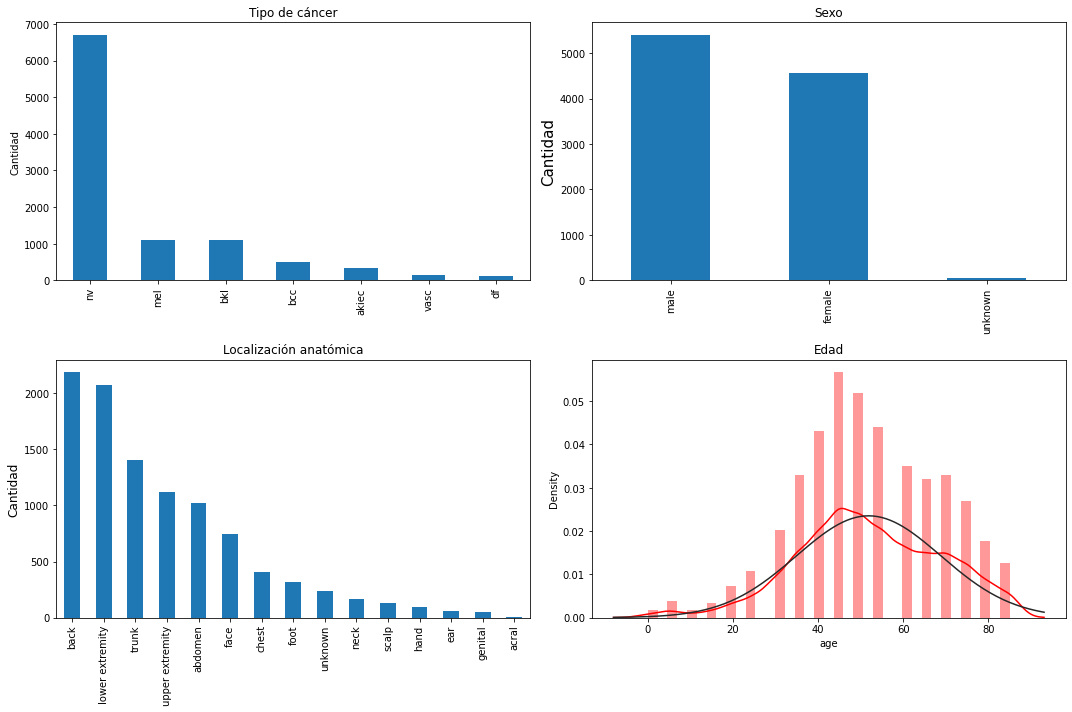

In [5]:
#Ver la distribución de los datos
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
data_skin['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Cantidad')
ax1.set_title('Tipo de cáncer');

ax2 = fig.add_subplot(222)
data_skin['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Cantidad', size=15)
ax2.set_title('Sexo');

ax3 = fig.add_subplot(223)
data_skin['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Cantidad',size=12)
ax3.set_title('Localización anatómica')

ax4 = fig.add_subplot(224)
sample_age = data_skin[pd.notnull(data_skin['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Edad')

plt.tight_layout()
plt.show()

In [6]:
#Contar la cantidad de imágenes de cada clase
data_skin['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [7]:
#Definir el submuestreo a utilizar para balancear la base de datos
limite_clases = data_skin['dx'].value_counts()[2]
limite_clases

1099

In [8]:
#Extraer las imágenes submuestreadas en dataframes separados
df_type_0 = data_skin[data_skin['dx']=='nv'][0:limite_clases]
df_type_1 = data_skin[data_skin['dx']=='mel'][0:limite_clases]
df_type_2 = data_skin[data_skin['dx']=='bkl'][0:limite_clases]

In [9]:
#Concatenar los dataframes separados en uno solo ya balanceado
data_skin_bal = pd.concat([df_type_0, df_type_1, df_type_2])

print(data_skin_bal['dx'].value_counts())

nv     1099
mel    1099
bkl    1099
Name: dx, dtype: int64


In [10]:
#Definición del etiquetador para las clases

l_encode = LabelEncoder()
l_encode.fit(data_skin_bal['dx'])
LabelEncoder()
print(list(l_encode.classes_))

['bkl', 'mel', 'nv']


In [11]:
#Etiquetamos cada clase existente en el dataframe balanceado
data_skin_bal['label'] = l_encode.transform(data_skin_bal['dx'])
print(data_skin_bal.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1701  HAM_0003506  ISIC_0033405  mel      histo  70.0    male   
3135  HAM_0003004  ISIC_0028889   nv  follow_up  65.0  female   
3293  HAM_0005055  ISIC_0030903   nv  follow_up  45.0    male   
3312  HAM_0002495  ISIC_0031330   nv  follow_up  45.0  female   
1750  HAM_0000119  ISIC_0033310  mel      histo  60.0    male   
3285  HAM_0003238  ISIC_0031157   nv  follow_up  45.0    male   
3542  HAM_0000927  ISIC_0027318   nv  follow_up  35.0  female   
3028  HAM_0007193  ISIC_0025398   nv  follow_up  45.0    male   
3747  HAM_0005111  ISIC_0030911   nv  follow_up  40.0  female   
1093  HAM_0005874  ISIC_0027326  bkl  consensus  75.0    male   

         localization  label  
1701  upper extremity      1  
3135            trunk      2  
3293            trunk      2  
3312  lower extremity      2  
1750             back      1  
3285            trunk      2  
3542          abdomen      2  
3028            trunk      2  
3747 

In [12]:
#Contamos la cantidad de imagenes de cada clase para verificar que se aplicó correctamente el balanceo de datos
data_skin_bal['dx'].value_counts()

nv     1099
mel    1099
bkl    1099
Name: dx, dtype: int64

In [ ]:
#Obtenemos todas las rutas de las imágenes a utilizar para el entrenamiento y validación del modelo
#Las imágenes se encuentran en carpetas individuales con el nombre de la clase
import glob
image_path = glob.glob('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_ORGANIZED/classes/**/*.jpg')

In [ ]:
#Código que solo se ejecuta una sola vez

#Creamos carpetas con el nombre de cada clase en un directorio de destino
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/bkl/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/mel/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/nv/')

In [ ]:
#Código que copia imágenes del directorio desbalanceado a un directorio balanceado
registro_id = []
for id in data_skin_bal['image_id']:
  registro_id.append(id)
  find_path = [s for s in image_path if id in s]
  for path in find_path:
    p = path.split('/')
    if 'bkl' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/bkl/')
    elif 'mel' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/mel/')
    elif 'nv' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/nv/')



In [ ]:
#Verificamos que se hayan copiado bien las imágenes al directorio balanceado
arc_akiec = os.listdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/nv/')
len(arc_akiec)

1099

# **Creación de Data Generator**

In [13]:
#Se crea el generador de imágenes, con normalización, data augmentation y con el 15% de las imágenes para validación
data_generator = ImageDataGenerator(rescale = 1.0/255.0,validation_split = 0.15,)

In [14]:
#Se define el generador de imágenes para el entrenamiento y la validación, con un batch de 32 e imágenes redimensionadas a 64x64 píxeles
path_classes = '/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/'
train_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (64,64),
    subset = 'training',
    seed = 123
)
val_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (64, 64),
    subset = 'validation',
    seed = 123
)

Found 2805 images belonging to 3 classes.
Found 492 images belonging to 3 classes.


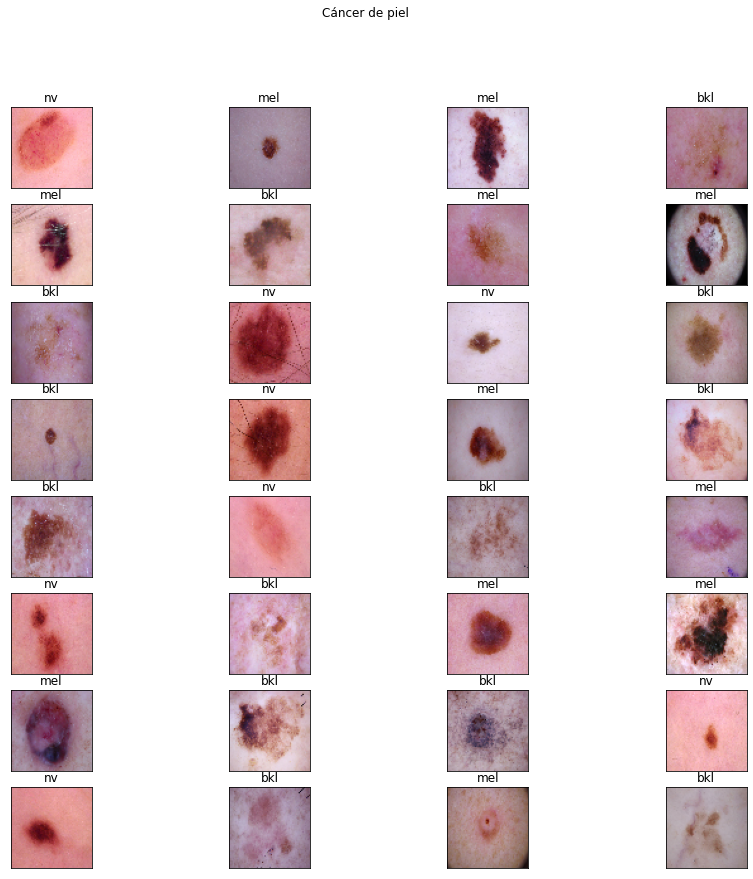

In [15]:
#Visualizamos las imágenes de un batch del generador de imágenes
x, y = next(train_image_generator)
classes = train_image_generator.class_indices
fig = plt.figure(figsize=(15,14))
fig.suptitle('Cáncer de piel')
for i in range(0, 32):
  image = x[i]
  y_search = y[i,:]
  idx = list(np.where(y_search==1))
  n_type = list(classes.keys())[list(classes.values()).index(idx[0])]
  fig.add_subplot(8,4,i+1)
  plt.imshow(image,cmap='gray')
  plt.title(n_type)
  plt.xticks([])
  plt.yticks([])
  n_type = ''

# **Carga de modelo pre-entrenado y sus métricas en .csv**

In [ ]:
#Linea de código opcional para cargar un modelo pre-entrenado en caso de que no logren entrenar durante 100 épocas seguidas
import csv

total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

model = load_model('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/90_epochs_cancer.h5')

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/acc_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_acc.append(float(fila[1]))
    total_acc = list(total_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_acc_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_acc.append(float(fila[1]))
    total_val_acc = list(total_val_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/loss_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_loss.append(float(fila[1]))
    total_loss = list(total_loss)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_loss_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_loss.append(float(fila[1]))
    total_val_loss = list(total_val_loss)

# **Definición de red neuronal convolucional**

In [21]:
#Se definen las clases y la estructura de la red neuronal convolucional
n_classes = 3

model = Sequential()
model.add(Conv2D(256, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(3, activation = 'softmax'))
model.summary()

#Compilamos el modelo, con una función de perdida categorical_crossentropy y un optimizador Adam
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)      

# **Entrenamiento de la red neuronal convolucional**

In [22]:
#Definimos vacios los contenedores de los resultados durante cada epoca (loss y acc)
total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

In [19]:
for i in range(0,10):
  print(i+1)

1
2
3
4
5
6
7
8
9
10


In [23]:
num_epochs = 10
for i in range(0,10):
  print("Batch de entrenamiento: "+str(i+1))
  #Entrenamiento del modelo
  historial = model.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
  #Guardamos cada 10 épocas de entrenamiento por seguridad en un archivo .h5
  model.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/MODELO_BASE/GPU/'+str((i+1)*10)+'_epochs_cancer.h5')
  #Obtenemos la función de perdida y su validación de cada 10 épocas
  loss = historial.history['loss']
  val_loss = historial.history['val_loss']
  #Obtenemos su precisión y la validación de cada 10 épocas
  acc = historial.history['acc']
  val_acc = historial.history['val_acc']
  #Guardamos los valores de función de perdida y precisión en vectores
  total_loss.extend(loss)
  total_val_loss.extend(val_loss)
  total_acc.extend(acc)
  total_val_acc.extend(val_acc)
  #Transformamos los vectores a dataframe
  df_loss = pd.DataFrame(total_loss)
  df_val_loss = pd.DataFrame(total_val_loss)
  df_acc = pd.DataFrame(total_acc)
  df_val_acc = pd.DataFrame(total_val_acc)
  #Guardamos los dataframes como archivos .csv para salvar la información
  df_loss.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/MODELO_BASE/GPU/loss_'+str((i+1)*10)+'.csv')
  df_val_loss.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/MODELO_BASE/GPU/val_loss_'+str((i+1)*10)+'.csv')
  df_acc.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/MODELO_BASE/GPU/acc_'+str((i+1)*10)+'.csv')
  df_val_acc.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/MODELO_BASE/GPU/val_acc_'+str((i+1)*10)+'.csv')



Batch de entrenamiento: 1
Epoch 1/10
87/87 [==============================] - 1578s 18s/step - loss: 0.8502 - acc: 0.5723 - val_loss: 0.6610 - val_acc: 0.7042
Epoch 2/10
87/87 [==============================] - 37s 421ms/step - loss: 0.6577 - acc: 0.6920 - val_loss: 0.6385 - val_acc: 0.6979
Epoch 3/10
87/87 [==============================] - 36s 419ms/step - loss: 0.5996 - acc: 0.7281 - val_loss: 0.5618 - val_acc: 0.7729
Epoch 4/10
87/87 [==============================] - 36s 410ms/step - loss: 0.5606 - acc: 0.7566 - val_loss: 0.7722 - val_acc: 0.6854
Epoch 5/10
87/87 [==============================] - 36s 417ms/step - loss: 0.5519 - acc: 0.7566 - val_loss: 0.6025 - val_acc: 0.7229
Epoch 6/10
87/87 [==============================] - 36s 415ms/step - loss: 0.5293 - acc: 0.7710 - val_loss: 0.5120 - val_acc: 0.8021
Epoch 7/10
87/87 [==============================] - 36s 419ms/step - loss: 0.5149 - acc: 0.7753 - val_loss: 0.4970 - val_acc: 0.8021
Epoch 8/10
87/87 [=========================

In [24]:
#Evaluamos la precisión final del modelo entrenado

score = model.evaluate(val_image_generator)
print('Test accuracy:', score[1])

16/16 [==============================] - 5s 334ms/step - loss: 0.5589 - acc: 0.7846
Test accuracy: 0.7845528721809387


# **Visualización gráfica de los entrenamientos (no ejecutar aún)**

In [ ]:
#En caso de ya contar con los archivos .csv de los entrenamientos, aquí se cargan

#Definimos vacios los contenedores de los resultados durante cada epoca (loss y acc)
total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

#Cargamos los archivos .csv de loss y accuracy, junto con su validación
with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/acc_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_acc.append(float(fila[1]))
    total_acc = list(total_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_acc_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_acc.append(float(fila[1]))
    total_val_acc = list(total_val_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/loss_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_loss.append(float(fila[1]))
    total_loss = list(total_loss)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_loss_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_loss.append(float(fila[1]))


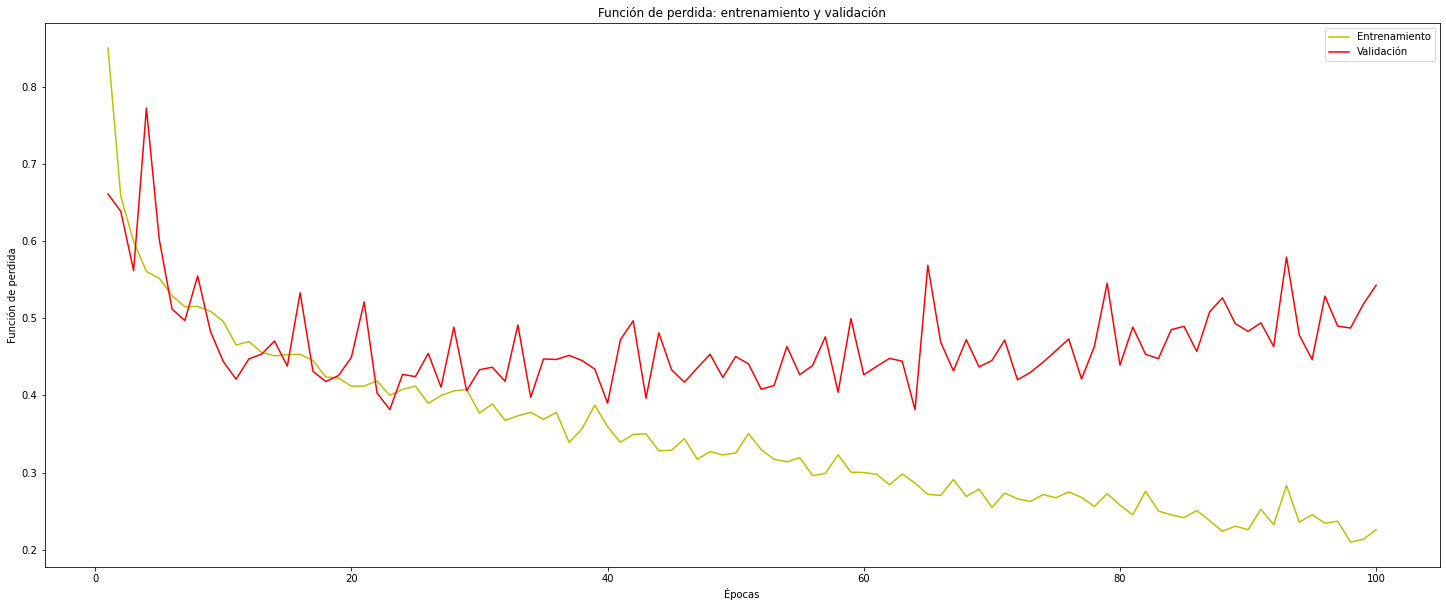

In [25]:
#Visualizamos la función de perdida y su validación
epochs = range(1, len(total_loss) + 1)
plt.figure(figsize=[25,10])
plt.plot(epochs, total_loss, 'y', label='Entrenamiento')
plt.plot(epochs, total_val_loss, 'r', label='Validación')
plt.title('Función de perdida: entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Función de perdida')
plt.legend()
plt.show()

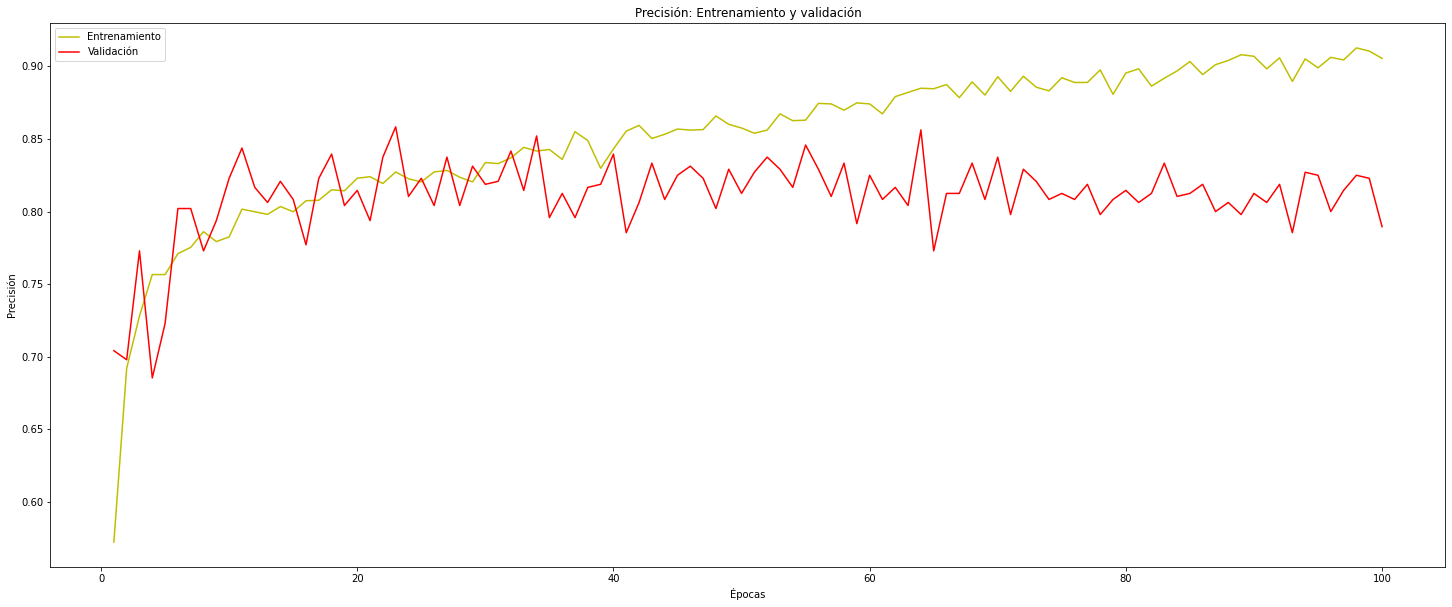

In [26]:
#Visualizamos el accuracy y su validación
epochs = range(1, len(total_acc) + 1)
plt.figure(figsize=[25,10])
plt.plot(epochs, total_acc, 'y', label='Entrenamiento')
plt.plot(epochs, total_val_acc, 'r', label='Validación')
plt.title('Precisión: Entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [27]:
!nvidia-smi

Thu Dec  8 16:21:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    28W /  70W |   4098MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------